   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.6.0+cu124:
      Successfully uninstalled torchaudio-2.6.0+cu124
Cloning into 'lag-llama'...
remote: Enumerating objects: 489, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 489 (delta 149), reused 109 (delta 109), pack-reused 312 (from 3)
Receiving objects: 100% (489/489), 277.77 KiB | 16.34 MiB/s, done.
Resolving deltas: 100% (247/247), done.
/content/lag-llama/lag-llama/lag-llama/lag-llama


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


lag-llama.ckpt:   0%|          | 0.00/29.5M [00:00<?, ?B/s]

PyTorch version: 2.0.1+cu117
CUDA available: False


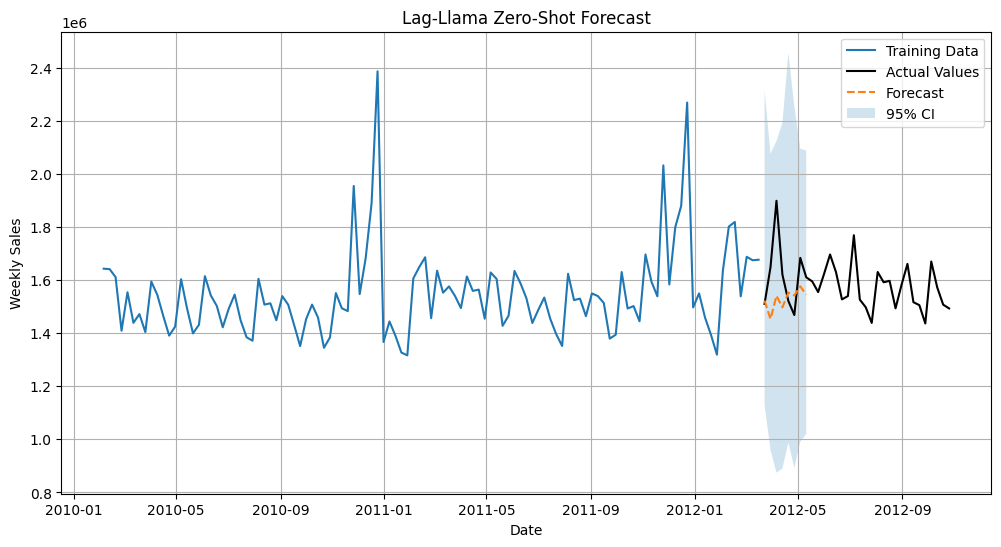

In [4]:
# First, install the correct versions of PyTorch and dependencies
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2
!pip install gluonts pandas numpy matplotlib

# Clone Lag-Llama repository and install requirements
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd lag-llama
!pip install -r requirements.txt

# Install huggingface-hub for downloading model weights
!pip install huggingface-hub

# Download model weights
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="time-series-foundation-models/Lag-Llama",
                filename="lag-llama.ckpt",
                local_dir=".")

# Now import libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.dataset.pandas import PandasDataset

# Need to add the current directory to Python path to import LagLlamaEstimator
import sys
sys.path.append('/content/lag-llama')
from lag_llama.gluon.estimator import LagLlamaEstimator

# Verify PyTorch installation
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Load and prepare data
url = 'https://raw.githubusercontent.com/marcopeix/FoundationModelsForTimeSeriesForecasting/main/data/walmart_sales_small.csv'
df = pd.read_csv(url, parse_dates=['Date'])
df = df[df['Store'] == 1]  # Focus on Store 1
df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

# Split data
test_size = 32
train_df = df[:-test_size]
test_df = df[-test_size:]

# Format data for GluonTS
train_ds = PandasDataset.from_long_dataframe(train_df, target="Weekly_Sales", item_id="Store")

# Zero-shot forecasting function
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecasts = list(predictor.predict(dataset=dataset))
    return forecasts

# Get zero-shot predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prediction_length = 8
forecasts = get_lag_llama_predictions(train_ds, prediction_length, device)

# Process predictions
def get_median_and_ci(data, start_date, horizon, freq, id, confidence=0.95):
    medians = np.median(data, axis=0)
    lower_bounds = np.percentile(data, (1 - confidence)/2 * 100, axis=0)
    upper_bounds = np.percentile(data, (1 + confidence)/2 * 100, axis=0)

    pred_dates = pd.date_range(start=start_date, periods=horizon, freq=freq)
    formatted_dates = pred_dates.strftime('%Y-%m-%d').tolist()

    return pd.DataFrame({
        'Date': formatted_dates,
        'Store': id,
        'Lag-Llama': medians,
        f'Lag-Llama-lo-{int(confidence*100)}': lower_bounds,
        f'Lag-Llama-hi-{int(confidence*100)}': upper_bounds
    })

# Get predictions for plotting
start_date = test_df.iloc[0]['Date']
preds_df = get_median_and_ci(
    forecasts[0].samples,
    start_date=start_date,
    horizon=prediction_length,
    freq='W-FRI',
    id=1
)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Weekly_Sales'], label='Training Data')
plt.plot(test_df['Date'], test_df['Weekly_Sales'], label='Actual Values', color='black')
plt.plot(pd.to_datetime(preds_df['Date']), preds_df['Lag-Llama'], label='Forecast', linestyle='--')
plt.fill_between(pd.to_datetime(preds_df['Date']),
                preds_df['Lag-Llama-lo-95'],
                preds_df['Lag-Llama-hi-95'],
                alpha=0.2, label='95% CI')
plt.title('Lag-Llama Zero-Shot Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid()
plt.show()